## Burst Initiation

> Here we test different properties of the underlying graph to narrow down the initiation sites of the bursts.

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing

import nngt
import nest
import nngt.simulation as ns
from pathlib import Path

from modules import simulation as nsim
from modules import percolation as per
from modules import analysis

from importlib import reload
#reload(nsim)
#reload(per)
#reload(analysis)

In [19]:
num_omp = multiprocessing.cpu_count() #Number of cores on the system

# network Parameters
w = 100.
ds = 0.01
do = 2.
deg = 100.
N = 500
l = 500.
R = 1000

from fromMallory.Neurons_Parameters import di_RS

params = di_RS
params['nb_neurons'] = N
print(params)

{'tau_w': 300.0, 'Delta_T': 1.8, 'tau_syn_ex': 0.2, 'V_m': -51.0, 'g_L': 12.01, 'I_e': 262.0, 'C_m': 200.0, 'b': 70.0, 'w': 37.0, 'V_th': -50.0, 't_ref': 2.0, 'V_peak': 30.0, 'a': 2.0, 'V_reset': -48.0, 'nb_neurons': 500, 'E_L': -70.0}


Making Network


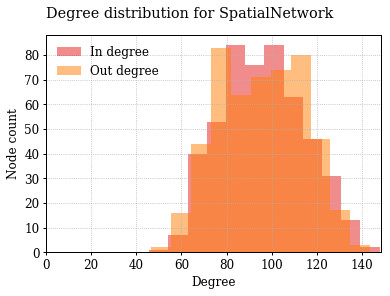

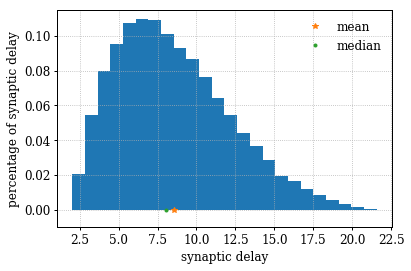

In [20]:
# Make the network
net = nsim.Make_Network(None, num_omp = num_omp, culture_radius = R, num_neurons = N, \
                        avg_deg = deg, lambda_edr = l, delay_slope = ds, delay_offset = do, syn_weight = w,\
                        neuron_params = {'neuron' : params}, plot_degrees=True, plot_delays=True)

In [14]:
#.plot.draw_network(net)

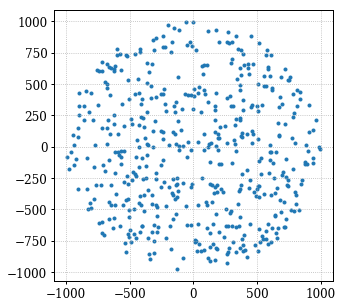

In [21]:
plt.figure(figsize=(5,5))
plt.scatter(net.get_positions()[:,0],net.get_positions()[:,1],marker='.')

In [26]:
# Simulate
senders , spikes, recorder,recorded, vms, vms_time = nsim.Simulation(net, num_omp= num_omp, \
                                    sim_time = 15000, noise_rate = 15., noise_weight_fraction = 0.5,\
                                   noise = 'Minis', save_spk = "data/spk", show_activity = False, return_activity = True,\
                                   animation = False, anim_name = "data/anim.mp4")

Start Simulation
Simulation done


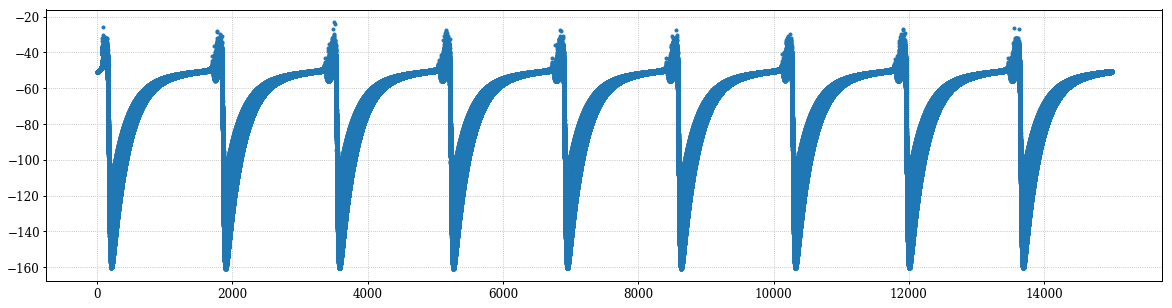

In [27]:
plt.figure(figsize=(20,5))
plt.plot(vms_time,vms,'.')
#plt.plot(vms_time[10::N],vms[10::N],'.')
#plt.plot(vms_time[20::N],vms[20::N],'.')
#plt.plot(vms_time[30::N],vms[30::N],'.')
#plt.plot(vms_time[40::N],vms[40::N],'.')
#plt.plot(vms_time[50::N],vms[50::N],'.')

In [25]:
burst_times, burst_neurons = analysis.getBursts(net=net, spikes=spikes, senders=senders, num_neurons=N, vms_time=vms_time,\
                         vms=vms, sim_time=15000, interburst_time=800, plot_overlay=True, plot_bursts=True, plot_rasters=True)

ValueError: min() arg is an empty sequence

In [8]:
print([len(burst_neurons[i]) for i in range(len(burst_neurons))])

[1656, 1597, 1563, 1560, 1567, 1566, 1584, 1557, 1574, 1573, 1573]


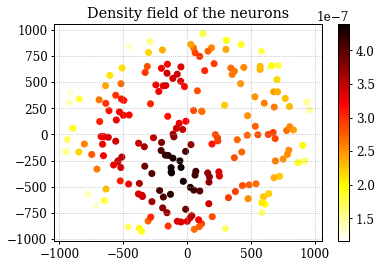

In [178]:
#Plotting the spatial density of the nodes:
from scipy.stats import gaussian_kde

x = net.get_positions()[:,0]
y = net.get_positions()[:,1]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
cax = ax.scatter(x, y, c=z, s=50, edgecolor='',cmap='hot_r')
fig.colorbar(cax)
plt.title('Density field of the neurons')
plt.show()

In [86]:
in_degree = nngt.analysis.node_attributes(net,'in-degree')
out_degree = nngt.analysis.node_attributes(net,'out-degree')

Text(0.5,1,'out-degree spatial distribution')

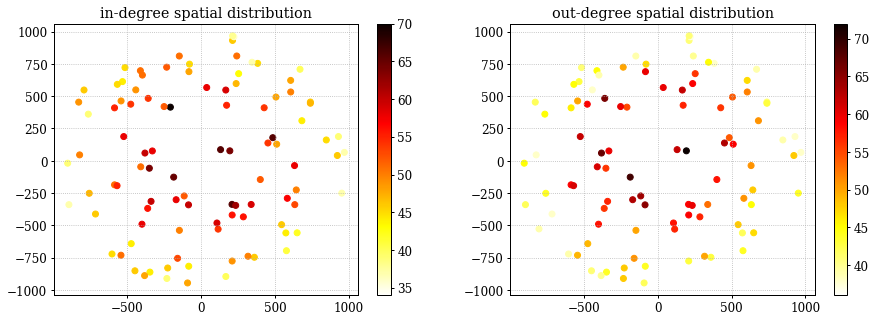

In [87]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(x,y,c=in_degree,cmap='hot_r')
plt.colorbar()
plt.title('in-degree spatial distribution')

plt.subplot(122)
plt.scatter(x,y,c=out_degree,cmap='hot_r')
plt.colorbar()
plt.title('out-degree spatial distribution')

Text(0.5,1,'out-degree + in-degree spatial distribution')

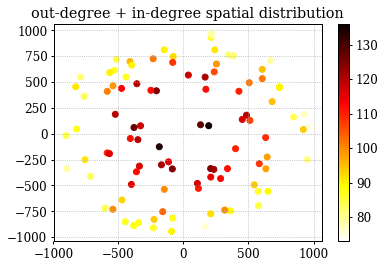

In [88]:
plt.scatter(x,y,c=out_degree + in_degree,cmap='hot_r')
plt.colorbar()
plt.title('out-degree + in-degree spatial distribution')

In [14]:
nngt.analysis.num_scc(net)

1

In [15]:
# Plot Average Synaptic delays spatially:
delays_neurons_in  = np.zeros(net.node_nb())
delays_neurons_out = np.zeros(net.node_nb())

for i in range(0,net.node_nb()):
    delays_neurons_in[i] = np.mean((net.get_delays()[np.where(np.asarray((net.edges))[:,1] == i)]))
    delays_neurons_out[i] = np.mean((net.get_delays()[np.where(np.asarray((net.edges))[:,0] == i)]))

Text(0.5,1,'out-delay mean spatial distribution')

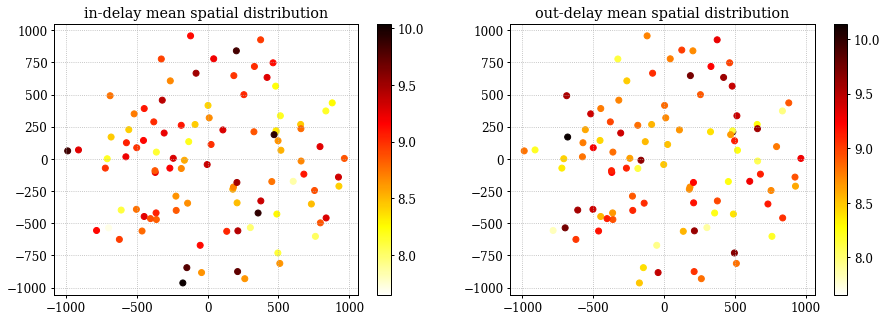

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(x,y,c=delays_neurons_in,cmap='hot_r')
plt.colorbar()
plt.title('in-delay mean spatial distribution')

plt.subplot(122)
plt.scatter(x,y,c=delays_neurons_out,cmap='hot_r')
plt.colorbar()
plt.title('out-delay mean spatial distribution')

In [17]:
entropy_neurons_in  = np.zeros(net.node_nb())
entropy_neurons_out = np.zeros(net.node_nb())

for i in range(0,net.node_nb()):
    entropy_neurons_in[i] = sc.stats.entropy(net.get_delays()[np.where(np.asarray((net.edges))[:,1] == i)])
    entropy_neurons_out[i] = sc.stats.entropy(net.get_delays()[np.where(np.asarray((net.edges))[:,0] == i)])

Text(0.5,1,'out-delay entropy spatial distribution')

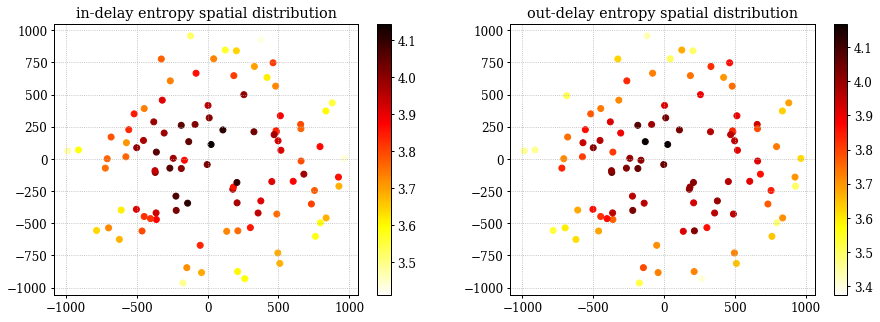

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(x,y,c=entropy_neurons_in,cmap='hot_r')
plt.colorbar()
plt.title('in-delay entropy spatial distribution')

plt.subplot(122)
plt.scatter(x,y,c=entropy_neurons_out,cmap='hot_r')
plt.colorbar()
plt.title('out-delay entropy spatial distribution')

In [19]:
invdelay_neurons_in  = np.zeros(net.node_nb())
invdelay_neurons_out = np.zeros(net.node_nb())

for i in range(0,net.node_nb()):
    invdelay_neurons_in[i] = np.mean(1./net.get_delays()[np.where(np.asarray((net.edges))[:,1] == i)])
    invdelay_neurons_out[i] = np.mean(1./net.get_delays()[np.where(np.asarray((net.edges))[:,0] == i)])

Text(0.5,1,'out-delay inverse mean spatial distribution')

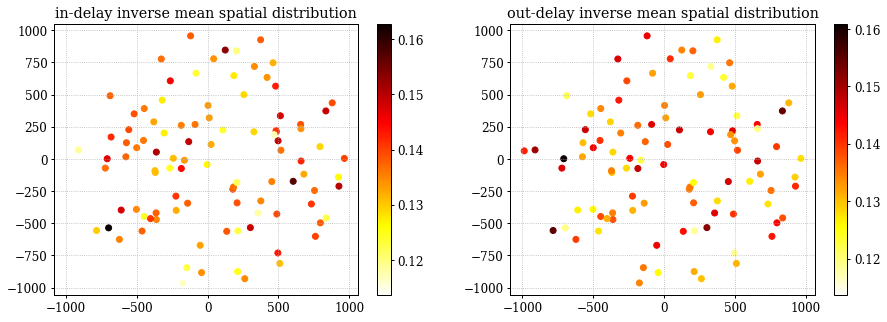

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(x,y,c=invdelay_neurons_in,cmap='hot_r')
plt.colorbar()
plt.title('in-delay inverse mean spatial distribution')

plt.subplot(122)
plt.scatter(x,y,c=invdelay_neurons_out,cmap='hot_r')
plt.colorbar()
plt.title('out-delay inverse mean spatial distribution')

In [21]:
from networkx.algorithms import cluster

clus = cluster.clustering(net.to_undirected())
gen_degree = cluster.generalized_degree(net.to_undirected())
sq_clus = cluster.square_clustering(net)

Text(0.5,1,'Square Clustering Coefficient spatial distribution')

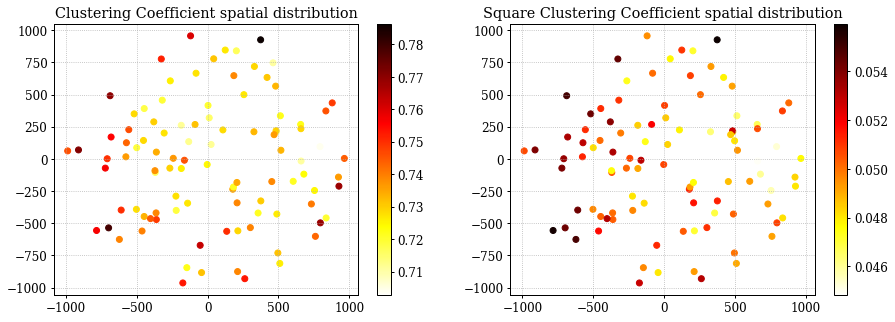

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(x,y,c=list(clus.values()),cmap='hot_r')
plt.colorbar()
plt.title('Clustering Coefficient spatial distribution')


#plt.subplot(132)
#plt.figure(figsize=(15,5))
#plt.subplot(121)
#plt.scatter(x,y,c=list(gen_degree.values()),cmap='hot_r')
#plt.colorbar()
#plt.title('Clustering Coefficient spatial distribution')

plt.subplot(122)
plt.scatter(x,y,c=list(sq_clus.values()),cmap='hot_r')
plt.colorbar()
plt.title('Square Clustering Coefficient spatial distribution')

### From the dynamical equation, check the form of the delay factor for each neuron:

In [23]:
# Plot Average Synaptic delays spatially:
delay_factor  = np.zeros(net.node_nb())
time  = 1500.
Tau_s = 0.2

for i in range(0,net.node_nb()):
    delays_neurons = net.get_delays()[np.where(np.asarray((net.edges))[:,1] == i)]
    delays_neurons_out = net.get_delays()[np.where(np.asarray((net.edges))[:,0] == i)]
    int_temp = 0.
    for j in range(len(delays_neurons)):
        if j != i:
            f = lambda t: (t - delays_neurons[j])*np.exp(- (t - delays_neurons[j])/Tau_s )
            zeta,_ = sc.integrate.quad(f,delays_neurons[j],time)
            int_temp =  int_temp + zeta
    #for j in range(len(delays_neurons_out)):
    #    f = lambda t: (t - delays_neurons_out[j])*np.exp(-(t - delays_neurons_out[j])/Tau_s )
    #    zeta,_ = sc.integrate.quad(f,delays_neurons_out[j],time)
    #    int_temp =  int_temp - zeta
    delay_factor[i] = int_temp

Text(0.5,1,'delay factor spatial distribution')

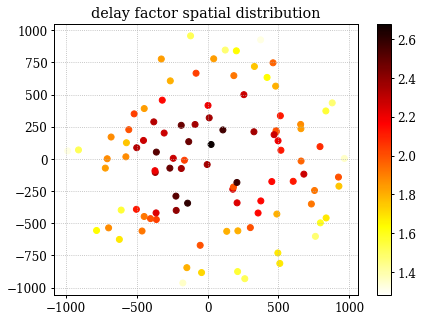

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(x,y,c=delay_factor,cmap='hot_r')
plt.colorbar()
plt.title('delay factor spatial distribution')

Text(0.5,1,'delay factor spatial distribution')

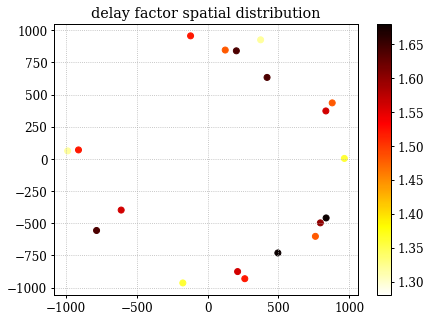

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(x[(np.argsort(delay_factor))[0:20]] ,y[(np.argsort(delay_factor))[0:20]], c = np.sort(delay_factor)[0:20],cmap='hot_r')
plt.colorbar()
plt.title('delay factor spatial distribution')

In [111]:
reload(nsim)

num_trials = 10
top_percent = 0.05

b_time, b_neurons,b_pred_neuron = [], [], []

for k in range(num_trials):
    
    params = di_RS
    params['nb_neurons'] = N
    
    # Make the network
    net = nsim.Make_Network(None, num_omp = num_omp, culture_radius = R, num_neurons = N, \
                        avg_deg = deg, lambda_edr = l, delay_slope = ds, delay_offset = do, syn_weight = w,\
                        neuron_params = {'neuron' : params}, plot_degrees=False, plot_delays=False)
    
    senders , spikes, recorder,recorded, vms, vms_time = nsim.Simulation(net, num_omp= num_omp, \
                                    sim_time = 15000, noise_rate = 100., noise_weight_fraction = 0.5,\
                                   noise = 'Minis', save_spk = "data/spk", show_activity = False, return_activity = True,\
                                   animation = False, anim_name = "data/anim.mp4")
    
    z,q = analysis.getBursts(net=net, spikes=spikes, senders=senders, num_neurons=N, vms_time=vms_time,\
                         vms=vms, sim_time=15000, interburst_time=800, plot_overlay=False, plot_bursts=False, plot_rasters=False)
    
   
    delay_factor  = np.zeros(net.node_nb())
    time  = 1500.
    Tau_s = 0.2

    for i in range(0,net.node_nb()):
        delays_neurons = net.get_delays()[np.where(np.asarray((net.edges))[:,1] == i)]
        delays_neurons_out = net.get_delays()[np.where(np.asarray((net.edges))[:,0] == i)]
        int_temp = 0.
        for j in range(len(delays_neurons)):
            if j != i:
                f = lambda t: (t - delays_neurons[j])*np.exp(- (t - delays_neurons[j])/Tau_s )
                zeta,_ = sc.integrate.quad(f,delays_neurons[j],time)
                int_temp =  int_temp + zeta
        delay_factor[i] = int_temp
    
    for j in range(len(z)):
        b_time.append(np.sort(z[j])[0:int(top_percent*N)])
        b_neurons.append(q[j][np.argsort(z[j])[0:int(top_percent*N)]])
        b_pred_neuron.append(np.argsort(delay_factor)[0:int(top_percent*N)])
    
    

Making Network
Start Simulation
Simulation done
Making Network
Start Simulation
Simulation done
Making Network
Start Simulation
Simulation done
Making Network
Start Simulation
Simulation done
Making Network
Start Simulation
Simulation done
Making Network
Start Simulation
Simulation done
Making Network
Start Simulation
Simulation done
Making Network
Start Simulation
Simulation done
Making Network
Start Simulation
Simulation done
Making Network
Start Simulation
Simulation done


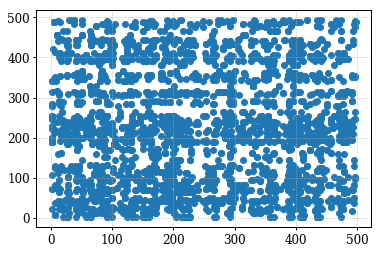

In [112]:
plt.scatter(b_neurons,b_pred_neuron)

## Solving the differential equation to get to V_th:

In [184]:
def diffEqn_V(y,t,par,net,syn_weight,burst_time_neurons_ind,delays_neurons,delays_id):
    
    N    = net.node_nb() 
    dydt = np.zeros(len(y))
    a    = par['g_L']/par['C_m']
    b    = (par['g_L']*par['E_L'] + par['I_e'])/par['C_m']
    I0   = (par['g_L']*par['Delta_T'])
    
    #Imini = Minis noise term
    Imini = (par['g_L']*par['Delta_T'])
    
    for i in range(0,N):
        int_temp = 0.
        for j in range(len(delays_neurons[i])):
            for k in range(len(burst_time_neurons_ind[delays_id[i][j]])):
                
                int_temp += np.heaviside(t - delays_neurons[i][j] - burst_time_neurons_ind[delays_id[i][j]][k],0)*\
                (t - delays_neurons[i][j] - burst_time_neurons_ind[delays_id[i][j]][k])*\
                np.exp(- (t - delays_neurons[i][j] - burst_time_neurons_ind[delays_id[i][j]][k] )/par['tau_syn_ex'] )
                
        dydt[i] = int_temp*I0*syn_weight/par['C_m']  + b - a*y[i] - y[i+N]/par['C_m'] \
        + par['g_L']*par['Delta_T']*np.exp((y[i]-par['V_th'])/par['Delta_T'])/par['C_m']
    
    for i in range(N,len(y)):
        dydt[i] = (par['a']*(y[i-N] - par['E_L']) - y[i])/par['tau_w'] 
    
    return dydt

In [ ]:
init_v                 = np.zeros(2*N)
burst_time_neurons_ind = []
delays_id              = []
delays_neurons         = []

for i in range(N):
    z = np.nonzero((vms_time[i::N] - np.max(burst_times[0])) >= 0)
    init_v[i] = vms[i::N][z[0][10]]
    burst_time_neurons_ind.append(burst_times[0][burst_neurons[0] == i+1])
    delays_id.append((np.asarray(net.edges))[np.where(np.asarray((net.edges))[:,1] == i)][:,0])
    delays_neurons.append(net.get_delays()[np.where(np.asarray((net.edges))[:,1] == i)])

for i in range(N,2*N):
    init_v[i] = params['w'] + params['b']*len(np.nonzero(burst_neurons[0] == i-N+1))
    
t   = np.linspace(vms_time[::N][z[0][10]],1000,250)
sol = sc.integrate.odeint(diffEqn_V, init_v, t, args=(params,net,w,burst_time_neurons_ind,delays_neurons,delays_id))

In [ ]:
plt.plot(sol[:,0],'.')

In [188]:
time_first = np.zeros(N)
for i in range(N):
    time_first[i] = t[np.where(sol[:,i] - (-50) >=0 )][0]

Text(0.5,1,'delay factor spatial distribution')

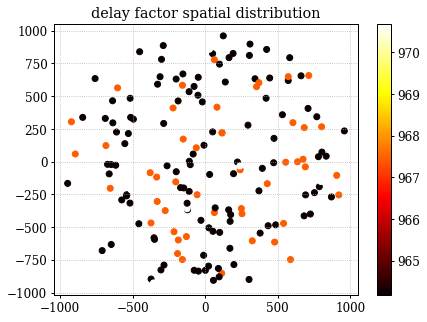

In [189]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(x,y,c=time_first,cmap='hot')
plt.colorbar()
plt.title('delay factor spatial distribution')